In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from sklearn.preprocessing import StandardScaler

In [2]:
load = pd.read_csv('C:/Users/volco/AdvancedBA/Data/load.csv')
prices = pd.read_csv('C:/Users/volco/AdvancedBA/Data/prices.csv')
res_gen = pd.read_csv('C:/Users/volco/AdvancedBA/Data/res_gen.csv')
residual_gen = pd.read_csv('C:/Users/volco/AdvancedBA/Data/residual_generation.csv')

load['date'] = pd.to_datetime(load['date'])
prices['date'] = pd.to_datetime(prices['date'])
res_gen['date'] = pd.to_datetime(res_gen['date'])
residual_gen['date'] = pd.to_datetime(residual_gen['date'])

# Convert all price columns to numeric, coercing errors to NaN for non-numeric values in 'price_FRA'
for col in ['price_AT', 'price_BE', 'price_FRA', 'price_GER', 'price_NL']:
    prices[col] = pd.to_numeric(prices[col], errors='coerce')

missing_values_prices = prices.isnull().sum()

prices.fillna(prices.mean(), inplace=True)

In [3]:
import numpy as np
import pandas as pd


# Assuming we're focusing on one region for simplicity
prices = prices['price_BE'].values  # Example: Focusing on Belgium

# Discretize prices into categories (low, medium, high) for simplicity
price_bins = pd.qcut(prices, q=3, labels=False, duplicates='drop')

# Parameters
battery_capacity = 100  # kWh
charge_discharge_rate = 10  # kW per hour
total_hours = len(prices)  # Total simulation hours

# Q-Table: Rows are states (battery levels + price levels), columns are actions (charge, discharge, do nothing)
num_battery_levels = 11  # 0-100% in 10% increments
num_price_levels = len(np.unique(price_bins))  # Number of unique price levels
num_actions = 3  # Charge, discharge, do nothing

# Initialize Q-table with zeros
Q = np.zeros((num_battery_levels * num_price_levels, num_actions))

# Learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate


In [4]:
def get_state_index(battery_level, price_level):
    """Calculate the index of the state in the Q-table."""
    return battery_level * num_price_levels + price_level

def choose_action(state_index):
    """Choose an action based on the epsilon-greedy policy."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(num_actions)  # Explore
    else:
        return np.argmax(Q[state_index])  # Exploit

def update_q_table(state_index, action, reward, next_state_index):
    """Update Q-table using the Q-learning algorithm."""
    best_next_action = np.argmax(Q[next_state_index])
    td_target = reward + gamma * Q[next_state_index][best_next_action]
    td_error = td_target - Q[state_index][action]
    Q[state_index][action] += alpha * td_error

# Simulation loop
for hour in range(1, total_hours):
    # Assume battery level is discretized in 10% steps for simplicity
    battery_level = np.random.randint(0, num_battery_levels)  # Random initial battery level
    price_level = price_bins[hour]  # Current price level
    
    state_index = get_state_index(battery_level, price_level)
    action = choose_action(state_index)  # Choose action based on the policy
    
    # Simplify reward calculation: reward for charging at low price, penalty for charging at high price
    reward = -prices[hour] if action == 0 else prices[hour] if action == 1 else 0
    
    # Update battery level based on action (simplified, without actual consumption or charging logic)
    battery_level = min(battery_level + 1, num_battery_levels - 1) if action == 0 else max(battery_level - 1, 0) if action == 1 else battery_level
    
    next_price_level = price_bins[hour + 1] if hour + 1 < total_hours else price_bins[hour]
    next_state_index = get_state_index(battery_level, next_price_level)
    
    # Update Q-table
    update_q_table(state_index, action, reward, next_state_index)


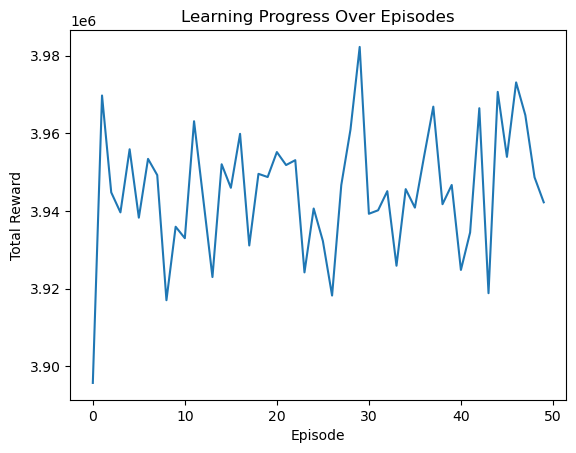

In [5]:
import matplotlib.pyplot as plt

# Additional parameters
num_episodes = 50  # Number of days to simulate
learning_rewards = []  # To track the sum of rewards for each episode

for episode in range(num_episodes):
    total_episode_reward = 0  # Sum of rewards for the current episode
    
    # Reset battery level at the start of the episode
    battery_level = np.random.randint(0, num_battery_levels)  # Random initial battery level
    
    for hour in range(1, total_hours - 1):  # Ensure we have a next state
        price_level = price_bins[hour]  # Current price level
        state_index = get_state_index(battery_level, price_level)
        
        action = choose_action(state_index)  # Choose action based on the policy
        
        # Simplify reward calculation: reward for charging at low price, penalty for charging at high price
        reward = -prices[hour] if action == 0 else prices[hour] if action == 1 else 0
        total_episode_reward += reward
        
        # Update battery level based on action (simplified, without actual consumption or charging logic)
        battery_level = min(battery_level + 1, num_battery_levels - 1) if action == 0 else max(battery_level - 1, 0) if action == 1 else battery_level
        
        next_price_level = price_bins[hour + 1]
        next_state_index = get_state_index(battery_level, next_price_level)
        
        # Update Q-table
        update_q_table(state_index, action, reward, next_state_index)
    
    learning_rewards.append(total_episode_reward)

# Plot learning progress
plt.plot(learning_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Progress Over Episodes')
plt.show()
